In [ ]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Image processing
import cv2
import os
import zipfile
from google.colab import files

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     BatchNormalization, LeakyReLU, GlobalAveragePooling2D)
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

# Evaluation metrics
from sklearn.metrics import f1_score

# Math functions
import math


In [ ]:
# Upload your ZIP dataset (data.zip)
uploaded = files.upload()

# Unzip it to /content/data
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print(f"Extracted {filename} successfully!")

# Check folder structure
os.listdir('/content/data')


Saving data.zip to data.zip
Extracted data.zip successfully!


['val', 'train']

In [ ]:
# Generators (28x28 input)
train_dir = '/content/data/train'
val_dir = '/content/data/val'

img_size = (28, 28)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,  # slightly more shift
    height_shift_range=0.15,
    zoom_range=[0.9, 1.2],   # allow slight zoom in/out
    shear_range=0.1,          # add small shear
    horizontal_flip=False,    # license plates usually not flipped
    brightness_range=[0.7,1.3], # simulate lighting variations
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
def custom_f1score(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    tp = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    precision = tp / (tf.cast(tf.size(y_pred_labels), tf.float32) + 1e-7)
    recall = tp / (tf.cast(tf.size(y_true), tf.float32) + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)


In [ ]:
# Clear previous session
K.clear_session()


model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=[custom_f1score]
)


In [ ]:
# Custom stop callback

class StopTrainingCallback(Callback):
    def __init__(self, monitor='val_custom_f1score', threshold=0.99):
        super().__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is not None:
            if current >= self.threshold:
                print(f"\nReached {self.threshold*100:.1f}% {self.monitor}. Stopping training!")
                self.model.stop_training = True
        else:
            print(f"Warning: Metric '{self.monitor}' not found in logs. Available metrics: {list(logs.keys())}")

# Initialize the callback
stop_callback = StopTrainingCallback(monitor='val_custom_f1score', threshold=0.99)


# Fit the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    verbose=1,
    callbacks=[stop_callback],
    steps_per_epoch=math.ceil(train_generator.samples / batch_size),
    validation_steps=math.ceil(val_generator.samples / batch_size)
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - custom_f1score: 0.9630 - loss: 0.1200
Reached 99.0% val_custom_f1score. Stopping training!
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - custom_f1score: 0.9626 - loss: 0.1210 - val_custom_f1score: 0.9955 - val_loss: 0.0260


In [ ]:

crop = files.upload()  # Upload indian_license_plate.xml

xml_file = list(crop.keys())[0]  # Name of uploaded XML
plate_cascade = cv2.CascadeClassifier(xml_file)

if plate_cascade.empty():
    raise Exception("Cascade XML not loaded!")
else:
    print("Cascade loaded successfully!")


Saving indian_license_plate.xml to indian_license_plate.xml
Cascade loaded successfully!


In [ ]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)

    plate = None  # default if nothing detected

    for (x, y, w, h) in plate_rect:
        # Optional: add padding (e.g., 5 pixels around)
        pad = 5
        x1 = max(x - pad, 0)
        y1 = max(y - pad, 0)
        x2 = min(x + w + pad, img.shape[1])
        y2 = min(y + h + pad, img.shape[0])

        roi_ = roi[y1:y2, x1:x2, :]
        plate = roi[y1:y2, x1:x2, :]
        # Draw rectangle around plate
        cv2.rectangle(plate_img, (x1, y1), (x2, y2), (51, 181, 155), 3)

        if text != '':
            plate_img = cv2.putText(plate_img, text, (x1, y1-5),
                                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.7, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate


In [ ]:
def display(img_, title=''):
    # Convert from BGR (OpenCV format) to RGB (Matplotlib format)
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

    # Create a 10x6 inch figure
    plt.figure(figsize=(10,6))

    # Show the image
    plt.imshow(img)
    plt.axis('off')      # remove axes
    plt.title(title)     # optional title
    plt.show()           # display inline


In [ ]:

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Save temporarily
with open(file_name, 'wb') as f:
    f.write(uploaded[file_name])

# Now you can use cv2.imread
img = cv2.imread(file_name)


Saving car5.webp to car5.webp


In [ ]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)


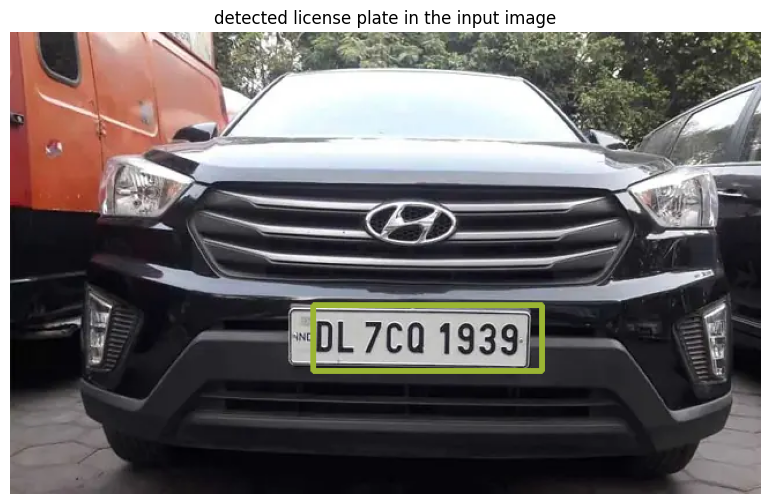

In [ ]:
display(output_img, 'detected license plate in the input image')


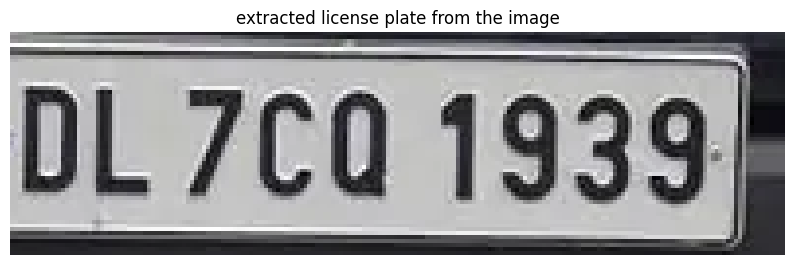

In [ ]:
display(plate, 'extracted license plate from the image')


In [ ]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

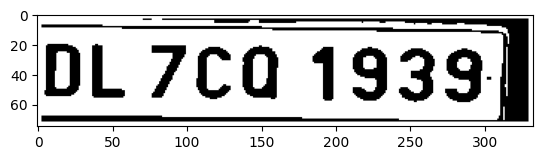

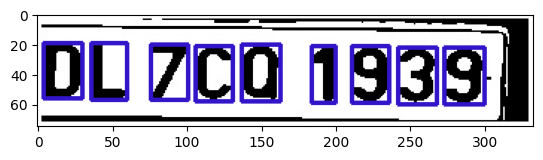

In [ ]:
# Let's see the segmented characters
char = segment_characters(plate)

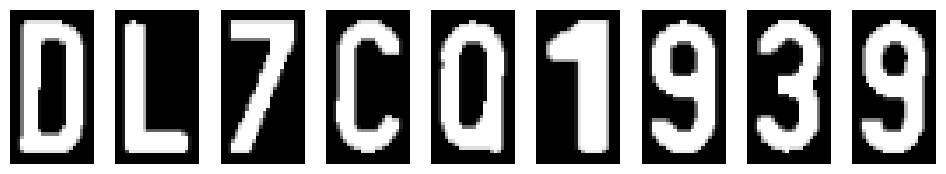

In [ ]:
plt.figure(figsize=(12,2))
for i, c in enumerate(char):  # iterate over actual characters
    plt.subplot(1, len(char), i+1)
    plt.imshow(c, cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:

def fix_dimension(img):
    """Convert single-channel grayscale image to 3-channel RGB."""
    new_img = np.stack([img]*3, axis=-1)  # shape: (28,28,3)
    return new_img

def show_results(char_images):
    """
    Predict the license plate number from segmented character images.

    Args:
        char_images: List of segmented character images (grayscale)

    Returns:
        plate_number: Predicted license plate string
    """
    # Mapping indices to characters
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    dic = {i: c for i, c in enumerate(characters)}

    output = []

    for ch in char_images:
        # Resize to 28x28
        img_resized = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        # Convert to 3 channels
        img_rgb = fix_dimension(img_resized)
        # Normalize
        img_rgb = img_rgb / 255.0
        # Add batch dimension
        img_batch = np.expand_dims(img_rgb, axis=0)  # shape: (1,28,28,3)
        # Predict class
        y_pred = model.predict(img_batch, verbose=0)
        class_idx = np.argmax(y_pred, axis=1)[0]
        # Map to character
        output.append(dic[class_idx])

    # Join all characters to get the plate number
    plate_number = ''.join(output)
    return plate_number


In [ ]:
predicted_plate = show_results(char)  # 'char_images' is your list of segmented characters
print("Predicted License Plate:", predicted_plate)


Predicted License Plate: DL7CQ1939


In [ ]:
model.save("model.h5")
from google.colab import files
files.download("model.h5")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>